## Simple CNN functions with numpy

This notebook showcases building some CNN functions using numpy, specifically:

* zero padding

* convolution forward pass

* pooling (max, average)

## 1. Load libs

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(7)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def zero_pad(X, pad):
    """
    Pad with zeros the images of dataset X
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0,0)), "constant", constant_values=(0,0))
    return X_pad

x.shape = (4, 3, 3, 1)
x_pad.shape = (4, 7, 7, 1)


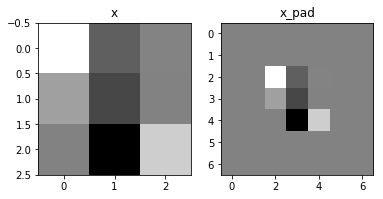

In [24]:
np.random.seed(7)

x = np.random.randn(4, 3, 3, 1)
x_pad = zero_pad(x, 2)
print("x.shape = {}".format(x.shape))
print("x_pad.shape = {}".format(x_pad.shape))

_, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [25]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """
    # Element-wise product of a_slice_prev and W
    s = a_slice_prev * W
    
    Z = np.sum(s)
    # cast b to float so Z returns a scalar value
    Z = Z + float(b)
    
    return Z

In [26]:
np.random.seed(7)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z = {}".format(Z))

Z = -6.359998188010675


In [27]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    n_H = int(np.floor((n_H_prev - f + 2*pad)/stride)) + 1
    n_W = int(np.floor((n_W_prev - f + 2*pad)/stride)) + 1
    
    Z = np.zeros((m, n_H, n_W, n_C))
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                    
    assert(Z.shape == (m, n_H, n_W, n_C))
    cache = (A_prev_pad, W, b, hparameters)
    
    return Z, cache

In [29]:
np.random.seed(7)

A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)

hparameters = {
    "pad": 2,
    "stride": 2
}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.41278185109159277
Z[3,2,1] = [-4.11098244  0.00992554 -0.64602682 -4.27469975  0.13846572 -0.55589245
  5.08703266  1.11798612]
cache_conv[0][1][2][3] = [0.23730185 0.10143399 0.25257774]


In [33]:
def pool_forward(A_prev, hparameters, mode="max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # dimensions of output
    n_H = int((n_H_prev - f) / stride) + 1
    n_W = int((n_W_prev - f) / stride) + 1
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    cache = (A_prev, hparameters)
    
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [36]:
np.random.seed(7)

A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride": 2, "f": 3}

A, _ = pool_forward(A_prev, hparameters)
print("mode=max")
print("A = {}".format(A))

A, _ = pool_forward(A_prev, hparameters, mode="average")
print("mode=average")
print("A = {}".format(A))

mode=max
A = [[[[1.6905257  1.07247013 1.65069969]]]


 [[[1.6995373  1.43823952 1.91201886]]]]
mode=average
A = [[[[-0.18362057 -0.39685526  0.01239972]]]


 [[[ 0.0238359  -0.45336177  0.25922475]]]]
